## Gaussian mixture model with Infer.Net

this is an implementation in python of the example https://dotnet.github.io/infer/userguide/Mixture%20of%20Gaussians%20tutorial.html (MixtureOfGaussians.cs in the source code). It's an example of a Gaussian mixture model with two components. 

In [1]:
import sys
sys.path.append(r'../dotNet/libs')

import clr
clr.AddReference("Microsoft.ML.Probabilistic")
clr.AddReference("Microsoft.ML.Probabilistic.Compiler")
clr.AddReference("Microsoft.ML.Probabilistic.Learners")

from System import Array, Double, Int32, Type, Converter
from utils import plot_graph

In [2]:
from Microsoft.ML.Probabilistic.Math import Rand, Vector, PositiveDefiniteMatrix
from Microsoft.ML.Probabilistic.Models import Variable, VariableArray, Range, InferenceEngine
from Microsoft.ML.Probabilistic.Algorithms import VariationalMessagePassing
from Microsoft.ML.Probabilistic.Distributions import Distribution, VectorGaussian, Gaussian, Gamma, Bernoulli, Discrete

In [3]:
# remove all previously generated graph files
!rm -f *.svg *.gv

### Define the mixture components

First we define the components in the mixture model with their priors. A Gaussian mixture model is constructed as a weighted sum of Gaussian distributions. In this case, we will construct a model containing two two-dimensional Gaussian distributions. The mean vector has a Gaussian prior, while the prior for the precision is modeled with a Wishart distribution. The weights are normalized (i.e. they sum to one), such that a two-dimensional Dirichlet distribution is a suitable prior.

In [4]:
# define number of components
k = Range(2).Named('k')

In [5]:
means = Variable.Array[Vector](k).Named('means')
means.set_Item(k, Variable.VectorGaussianFromMeanAndPrecision(
            Vector.FromArray(0.0, 0.0),
            PositiveDefiniteMatrix.IdentityScaledBy(2, 0.01)).ForEach(k))

In [6]:
precisions = Variable.Array[PositiveDefiniteMatrix](k).Named('precisions')
precisions.set_Item(k, Variable.WishartFromShapeAndScale(
    100.0, PositiveDefiniteMatrix.IdentityScaledBy(2, 0.01)).ForEach(k))

In [7]:
weights = Variable.Dirichlet(k, Array[Double]([1.0, 1.0])).Named('weights')

### Define the latent variable and data

For each data point, we associate a random latent variable that selects which component the data point belongs to. Each latent variable is sampled from a discrete distribution (possible values 0 and 1) with probabilities determined by the weights.

In [8]:
# define data range
n = Range(300).Named("n")

In [9]:
# latent (selector) variable
z = Variable.Array[int](n).Named('z')
z.set_Item(n, Variable.Discrete(weights).ForEach(n))

In [10]:
# connect the data samples to the associated mixture component
data = Variable.Array[Vector](n).Named('x')
for_each_block = Variable.ForEach(n)
switch_block = Variable.Switch(z.get_Item(n))
data.set_Item(n, Variable.VectorGaussianFromMeanAndPrecision(
    means.get_Item(z.get_Item(n)), 
    precisions.get_Item(z.get_Item(n))))
switch_block.CloseBlock()
for_each_block.CloseBlock()

### Generate data

The data is generated by random sampling from two Gaussian distributions.

In [11]:
def generate_data(count):
    true_means1 = Vector.FromArray(2.0, 3.0)
    true_means2 = Vector.FromArray(7.0, 5.0)
    
    p1 = Array.CreateInstance(Double, 2, 2)
    p1[0,0] = 3.0; p1[0,1] = 0.2; p1[1,0] = 0.2; p1[1,1] = 2.0
    p2 = Array.CreateInstance(Double, 2, 2)
    p2[0,0] = 2.0; p2[0,1] = 0.4; p2[1,0] = 0.4; p2[1,1] = 4.0
    
    true_precision1 = PositiveDefiniteMatrix(p1)
    true_precision2 = PositiveDefiniteMatrix(p2)
    
    true_distribution1 = VectorGaussian.FromMeanAndPrecision(
                            true_means1, true_precision1)
    true_distribution2 = VectorGaussian.FromMeanAndPrecision(
                            true_means2, true_precision2)
    
    is_component1 = Bernoulli(0.6)

    # Restart the infer.NET random number generator
    Rand.Restart(12347);
    
    data = Array.CreateInstance(Vector, count)
    for i in range(count):
        data[i] = true_distribution1.Sample() if is_component1.Sample() \
            else  true_distribution2.Sample()

    return data

In [12]:
data.ObservedValue = generate_data(n.SizeAsInt)

### Initialize the latent variables

Because the two Gaussian distributions are defined in the same way, they are not distinguishable during the inference update steps if all messages are initialized to zero. Hence, the inference will result in identical results for the two components. To break the symmetry we need to randomly initialize the messages. To see the effect without the random initialization, skip the next cell and run the inference directly.

In [13]:
z_init = Array.CreateInstance(Discrete, n.SizeAsInt)
for i in range(z_init.Length):
    z_init[i] = Discrete.PointMass(Rand.Int(k.SizeAsInt), k.SizeAsInt)
z.InitialiseTo(Distribution[int].Array[Discrete](z_init))

<Microsoft.ML.Probabilistic.Models.0, Culture=neutral, PublicKeyToken=b77a5c561934e089]] at 0x7f387f3444a8>

### Run the inference

Compute the marginal (posterior) distributions for the means and precisions of the Gaussian components and their weights.

In [14]:
engine = InferenceEngine(VariationalMessagePassing())
engine.ModelName = 'Gaussian_mixture'
engine.ShowFactorGraph = True

In [15]:
marginal_weights = engine.Infer(weights)
marginal_means = engine.Infer(means)
marginal_precisions = engine.Infer(precisions)

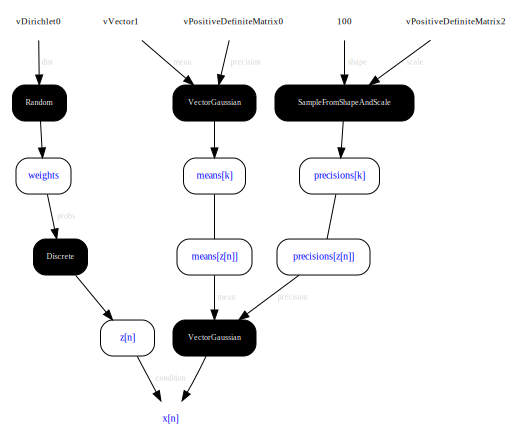

In [16]:
plot_graph(engine.ModelName)

In [17]:
print(f'Dist over weights = {marginal_weights}')
print(f'Dist over means = \n {marginal_means}')
print(f'Dist over precisions= \n {marginal_precisions}')

Dist over weights = Dirichlet(180 122)
Dist over means = 
 [0] VectorGaussian(2.033 2.897, 0.003775   -9.646e-05)
                                -9.646e-05 0.004307  
[1] VectorGaussian(7.041 4.986, 0.006446   -6.828e-05)
                                -6.828e-05 0.00586   
Dist over precisions= 
 [0] Wishart(189.5, 0.007813 0.000175)[mean=1.481   0.03316]
                   0.000175 0.006848       0.03316 1.298  
[1] Wishart(160.5, 0.007988  9.308e-05)[mean=1.282   0.01494]
                   9.308e-05 0.008788        0.01494 1.41   
